# Long/short Trading Strategy with Support Vector Machines (SVMs)

**1. Introduction**

- The aim is to implement SVM on a trading strategy for the Luxembourg index (LUXXX) based on other indices as well as technical indicators. 
- The strategy is to take a long/short position when 0.25% change in LUXXX return is predicted. 
- The long/short position will be based on an upward or downward trending market.
- This strategy does not take into account  trading costs.

In [99]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn import svm
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier

- Loading the data: The data contains weekly closing prices. 

In [100]:
data_df = pd.read_csv("data/luxxx.csv")
data_df.head(3)

,Date,LUXXX,MSCI ARGENTINA,BLP ORIENTE MEDIO,MSCI AUSTRALIA,MSCI AUSTRIA,MSCI BELGIUM,MSCI BRAZIL,MSCI CANADA,MSCI CHINA,...,MSCI NORWAY,MSCI PERU,MSCI RUSSIA,MSCI SINGAPORE,MSCI SOUTH AFRICA,MSCI SPAIN,MSCI SWEDEN,MSCI SWITZERLAND,MSCI UK,MSCI USA
0,01-Jan-16,1390.716,2376.29,3525.9150,1068.79,106.70,105.38,1036.23,1663.27,59.47,...,2373.17,811.96,404.73,1507.8101,1255.75,108.40,11136.65,1148.37,1818.40,1949.70
1,08-Jan-16,1291.267,2260.85,3280.6683,1005.56,97.66,99.35,952.01,1586.18,54.63,...,2209.38,751.09,388.05,1437.6600,1177.76,101.00,10389.93,1075.30,1722.00,1831.88
2,15-Jan-16,1257.086,2217.50,3118.2981,985.38,93.54,97.32,904.64,1541.08,51.54,...,2095.60,720.23,344.45,1372.9800,1133.72,97.34,10042.32,1056.01,1692.43,1789.56


- The 'Date' column is in a string format; therefore, convert it to a datetime format

In [101]:
data_df["Date"] = pd.to_datetime(data_df["Date"])

C:\Users\Asus\AppData\Local\Temp\ipykernel_6944\939905822.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data_df["Date"] = pd.to_datetime(data_df["Date"])


- Specifying the target column - the LUXXX index. The returns of LUXXX needs to be calculated since our strategy is based on the returns over the weeks. 
- The remaining indices are converted to returns instead of their prices; to scale the features into a common unit as well as to capture movements in the prices instead.

In [102]:
target_ETF = "LUXXX"

ETF_features = data_df.loc[:, ~data_df.columns.isin(["Date", target_ETF])].columns
data_df[ETF_features] = data_df[ETF_features].pct_change()

data_df[target_ETF + "_returns"] = data_df[target_ETF].pct_change()

- Next, we calculate the Target column and converts it into a categorical binary variable. 
- Denote 1 for the absolute returns of LUXXX exceeding 0.25% and 0 otherwise. In a downward or bear market, we look to short should the price decrease by more than this threshold, and we take a long position in a bear market. 
- The goal is to predict a percent change more than a threshold. 
- We shift the target column by one week to align with the predicted period available for other predictors since the ML algorithm re quires the label and feature/predictor values to be captured in the same row or observation.


In [103]:
data_df[target_ETF + "_returns" + "_shift"] = data_df[target_ETF + "_returns"].shift(-1)

# Strategy to take long position for anticipated returns of 0.5%
data_df["Target"] = np.where(
(data_df[target_ETF + "_returns_shift"].abs() > 0.025), 1, 0
)

In [104]:
# Checking target proportion
round(data_df["Target"].sum() / len(data_df), 4)

0.3452

- The proportion of 34.5% of the target class 1 does not indicate any imbalance.

- Now that we have our Target class, we can select which indices contribute to predicting the target class. We use the feature importance tool in Sklearn for a Decision Tree.
- We look at the cumulative importance for the features that make a contribution > 0. 

In [105]:
# Prepare for Train/Test split

NoNaN_df = data_df.dropna()
X = NoNaN_df[ETF_features]

X = X.iloc[:, :]
y = NoNaN_df.loc[:, "Target"]

del NoNaN_df

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

DTree = DecisionTreeClassifier(
    criterion="entropy",
    random_state=0,
    max_depth=8,
    min_samples_leaf=30,
    min_samples_split=20,
)

DTree.fit(X_train, y_train)

feature_importances = pd.DataFrame(
    DTree.feature_importances_,
    index=X.iloc[:, :].columns,
    columns=["importance"],
).sort_values("importance", ascending=False)

feature_importances["Cumul_Imp"] = feature_importances.cumsum().iloc[:, :]

pct_var = 1.0
feature_importances = feature_importances[(feature_importances["Cumul_Imp"] <= pct_var)]
feature_importances

,importance,Cumul_Imp
MSCI KOREA,0.436123,0.436123
MSCI DENMARK,0.219591,0.655713
MSCI FRANCE,0.196979,0.852692
MSCI NORWAY,0.147308,1.000000
MSCI ARGENTINA,0.000000,1.000000
MSCI PERU,0.000000,1.000000
MSCI MEXICO,0.000000,1.000000
MSCI NETHERLANDS,0.000000,1.000000
MSCI NEW ZEALAND,0.000000,1.000000
MSCI RUSSIA,0.000000,1.000000


- The cumulative importance shows only 4 indices that contribute, reducing features significantly and will also reduce the runtime when doing hyperparameter tuning.

              importance      Variable
MSCI KOREA      0.436123    MSCI KOREA
MSCI DENMARK    0.219591  MSCI DENMARK
MSCI FRANCE     0.196979   MSCI FRANCE
MSCI NORWAY     0.147308   MSCI NORWAY


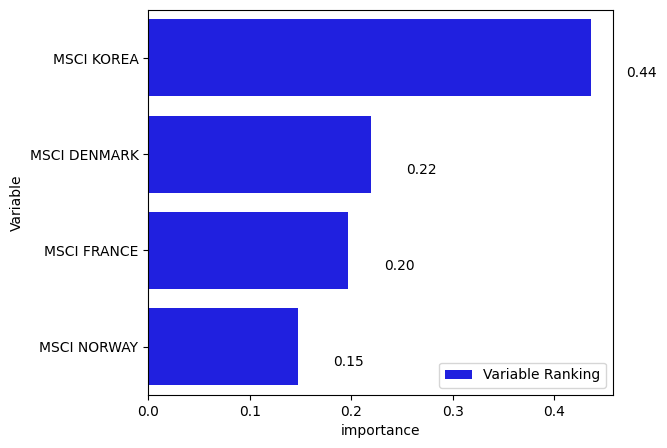

In [108]:
# Plot feature importance

cols = feature_importances.index
y_pos = np.arange(len(cols))
performance = feature_importances.importance

df2plot = pd.DataFrame(data=performance, index=feature_importances.index)
df2plot["Variable"] = feature_importances.index
df2plot = df2plot[df2plot["importance"] > 0.000]

print(df2plot)

f, ax = plt.subplots(figsize=(6,5))

sns.barplot(
    x="importance", y="Variable", data=df2plot, label="Variable Ranking", color="b"
)

for p in ax.patches:
    width = p.get_width()
    ax.text(
        width + 0.05,
        p.get_y() + p.get_height() / 2.0 + 0.2, 
        "{:1.2f}".format(width), 
        ha="center",
    )

In [110]:
# Indices to add value in prediction
ETF_ImpFeatures = []
for i in df2plot["Variable"].values:
    ETF_ImpFeatures.append(i)

ETF_ImpFeatures

['MSCI KOREA', 'MSCI DENMARK', 'MSCI FRANCE', 'MSCI NORWAY']